In [1]:
import os

os.chdir("../")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

import torch_optimizer as optimizer
from config import settings

import models.spinalnet_resnet as spinalnet_resnet
import models.effnet as effnet
import models.densenet as densenet
import models.spinalnet_vgg as spinalnet_vgg
import models.vitL16 as vitL16
import models.alexnet_vgg as alexnet_vgg
import models.resnet18 as resnet18
import models.baseline as baseline
import  data
# import data.segmentation as segmentation
# import metrics.metrics as metrics
from data import DataPart
from train import Trainer
import metrics

from comet_ml import Experiment



all_models = [
    ('Baseline', baseline),
    ('ResNet18', resnet18),
    ('EfficientNet', effnet),
    ('DenseNet', densenet),
    ('SpinalNet_ResNet', spinalnet_resnet),
    ('SpinalNet_VGG', spinalnet_vgg),
    ('ViTL16', vitL16),
    ('AlexNet_VGG', alexnet_vgg)
]

all_optimizers = [
    ('SGD', optim.SGD),
    ('Rprop', optim.Rprop),
    ('Adam', optim.Adam),
    ('NAdam', optim.NAdam),
    ('RAdam', optim.RAdam),
    ('AdamW', optim.AdamW),
    #('Adagrad', optim.Adagrad),
    ('RMSprop', optim.RMSprop),
    #('Adadelta', optim.Adadelta),
    ('DiffGrad', optimizer.DiffGrad),
    # ('LBFGS', optim.LBFGS)
]

In [2]:
from scipy.signal import savgol_filter

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
datasets, dataloaders = data.create_dataloaders()

train_loader = dataloaders[DataPart.TRAIN]
val_loader = dataloaders[DataPart.VALIDATE]
test_loader = dataloaders[DataPart.TEST_DR5]


/home/matvei/projects/galaxyHackers/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


INFO: Query finished. [astroquery.utils.tap.core]
252
84
84
244
85


In [4]:

# parser = argparse.ArgumentParser(description='Model training')
# parser.add_argument('--models', nargs='+', default=['ResNet18', 'EfficientNet', 'DenseNet', 'SpinalNet_ResNet', 'SpinalNet_VGG', 'ViTL16', 'AlexNet_VGG'],
#                     help='List of models to train (default: all)')
# parser.add_argument('--epochs', type=int, default=5, help='Number of epochs to train (default: 5)')
# parser.add_argument('--lr', type=float, default=0.0001, help='Learning rate for optimizer (default: 0.0001)')
# parser.add_argument('--mm', type=float, default=0.9, help='Momentum for optimizer (default: 0.9)')
# parser.add_argument('--optimizer', choices=[name for name, _ in all_optimizers], default='Adam', help='Optimizer to use (default: Adam)')

# args = parser.parse_args()

# selected_models = [(model_name, model) for model_name, model in models if model_name in args.models]

# num_epochs = args.epochs
# lr = args.lr
# momentum = args.mm
# optimizer_name = args.optimizer


In [5]:
selected_models = all_models[:1]

num_epochs = 200
lr = 1e-4
momentum = 0.9
optimizer_name = "Adam"




In [6]:
experiment = Experiment(
    api_key=settings.COMET_API_KEY,
    project_name="cluster-search",
    workspace=settings.COMET_WORKSPACE,
    auto_param_logging=False,
)

experiment.log_parameters(
    {
        "models": [name for name, _ in selected_models],
        "num_epochs": num_epochs,
        "momentum": momentum,
        "optimizer": optimizer_name,
    }
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pyatachokk/cluster-search/488cb243e4f1435e8f532d10bf04dc81



In [7]:

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

results = {}
val_results = {}

classes = ('random', 'clusters')


finding LR: 100%|██████████| 70/70 [00:08<00:00,  8.33it/s]


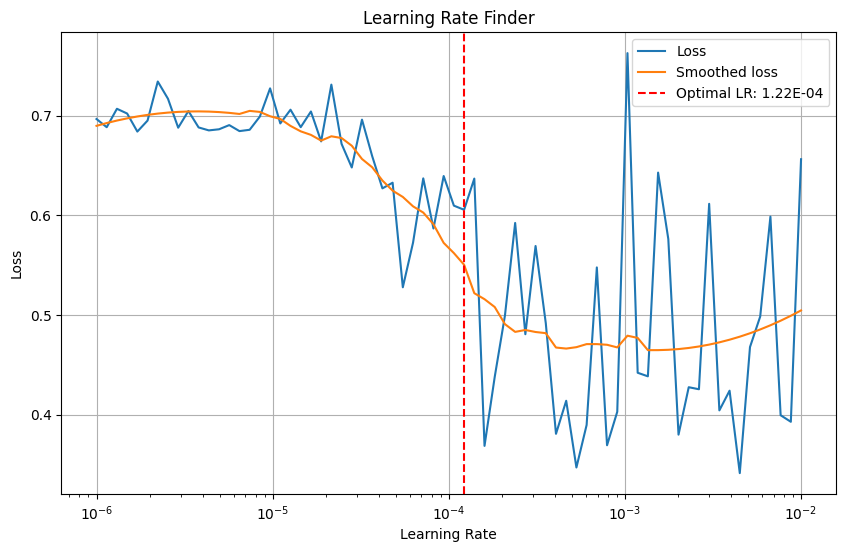

100%|██████████| 27/27 [00:01<00:00, 20.22it/s]
/home/matvei/projects/galaxyHackers/venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 27/27 [00:01<00:00, 20.70it/s]                                            
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     displ

In [8]:
for model_name, model in selected_models:

    model = model.load_model()
    optimizer_class = dict(all_optimizers)[optimizer_name]

    if optimizer_name in ["SGD", "RMSprop"]:
        optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum)
    else:
        optimizer = optimizer_class(model.parameters(), lr=lr)

    scheduler = ExponentialLR(optimizer, gamma=0.8)

    trainer = Trainer(
        model_name=model_name,
        model=model,
        criterion=criterion,
        optimizer_name=optimizer_name,
        optimizer=optimizer,
        lr_scheduler=scheduler,

        train_dataloader=train_loader,
        val_dataloader=val_loader,
        experiment=experiment
    )
    
    trainer.find_lr(1e-6, 0.01, 70)

    try:
        trainer.train(num_epochs)

    finally:

        predictions, *_ = trainer.test(test_loader)
        metrics.modelPerformance(model_name, optimizer_name, predictions, classes)

        metrics.combine_metrics(selected_models, optimizer_name)

        experiment.end()

        del model
        torch.cuda.empty_cache()


In [ ]:
import segmentation

model_name, model = selected_models[1]
for model_name, model in selected_models:
    segmentation.create_segmentation_plots(
        model, model_name, optimizer_name=optimizer_name
    )